# Загрузка и подготовка данных

https://colab.research.google.com/drive/1b51ZyZMPVqfJTKUpCGbu4Ep1wLhjJoUk?usp=sharing

In [1]:
from sklearn import model_selection, metrics
import pandas as pd

In [2]:
# получение датасета
df = pd.read_csv("../data/weather_preprocessed.csv")

In [3]:
# первые 5 записей из датасета
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,...,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_without_value,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_without_value,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_without_value
0,13.4,22.9,0.6,5.468232,7.611178,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.50993,16.9,21.8,0,0,2008,12,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,7.4,25.1,0.0,5.468232,7.611178,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,4.447461,4.50993,17.2,24.3,0,0,2008,12,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,12.9,25.7,0.0,5.468232,7.611178,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,4.447461,2.00000,21.0,23.2,0,0,2008,12,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,9.2,28.0,0.0,5.468232,7.611178,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,4.447461,4.50993,18.1,26.5,0,0,2008,12,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,17.5,32.3,1.0,5.468232,7.611178,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.00000,17.8,29.7,0,0,2008,12,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [4]:
# информация о датасете 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140787 entries, 0 to 140786
Columns: 121 entries, MinTemp to WindDir3pm_without_value
dtypes: float64(16), int64(105)
memory usage: 130.0 MB


In [5]:
# колиество нулевых элементов
df.isnull().sum()

MinTemp                     0
MaxTemp                     0
Rainfall                    0
Evaporation                 0
Sunshine                    0
                           ..
WindDir3pm_SW               0
WindDir3pm_W                0
WindDir3pm_WNW              0
WindDir3pm_WSW              0
WindDir3pm_without_value    0
Length: 121, dtype: int64

In [6]:
# разделение признаков
y = df['RainTomorrow'].values
df.pop('RainTomorrow')
X = df.values

In [7]:
# разделение датасета на обучаемую и тестовую выборки
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

In [8]:
# масштабирование признаков
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Архитектура и визуализация

In [9]:
# подключение модулей
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils

In [10]:
# архитектура нейросети
model = Sequential()
model.add(Dense(32, input_dim=X.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [11]:
# информацию о модели
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                3872      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________
None


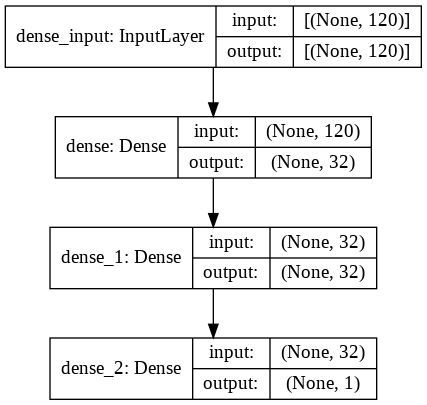

In [12]:
utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
# подготовка модели к процессу обучения
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
# обучение модели
model.fit(X_train, y_train)

3520/3520 [==============================] - 9s 2ms/step - loss: 0.3883 - accuracy: 0.8226


In [15]:
# предсказание модели
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     21937
           1       0.73      0.55      0.63      6221

    accuracy                           0.86     28158
   macro avg       0.81      0.75      0.77     28158
weighted avg       0.85      0.86      0.85     28158



# Подбор гиперпараметров и архитектуры

In [16]:
# Установка Keras Tuner
%pip install -U keras-tuner

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.7/dist-packages (1.0.2)


In [17]:
# функция для создания нейронной сети
def build_model(hp):
    model = Sequential()
    activation_choice = hp.Choice('activation', values=['relu', 'sigmoid', 'tanh', 'elu', 'selu'])    
    model.add(Dense(units=hp.Int('units1', min_value=10, max_value=167, step=4), input_dim=X.shape[1], activation=activation_choice))
    model.add(Dense(units=hp.Int('units2', min_value=15, max_value=254, step=6), activation=activation_choice))   
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam','rmsprop','SGD']), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [18]:
# модель для подбора гиперпараметров
from kerastuner.tuners import RandomSearch
model_tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=5, directory='../keras_models/')

In [19]:
# подбираемые гиперпараметры
model_tuner.search_space_summary()

Search space summary
Default search space size: 4
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh', 'elu', 'selu'], 'ordered': False}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 167, 'step': 4, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 15, 'max_value': 254, 'step': 6, 'sampling': None}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop', 'SGD'], 'ordered': False}


In [20]:
# подбор гиперпараметров
model_tuner.search(X_train, y_train, batch_size=20, epochs=15, validation_split=0.2)

Trial 5 Complete [00h 03m 15s]
val_accuracy: 0.8638462424278259

Best val_accuracy So Far: 0.8654443621635437
Total elapsed time: 00h 15m 52s
INFO:tensorflow:Oracle triggered exit


In [21]:
# результаты подбора гиперпараметров и архитектуры нейросети
model_tuner.results_summary()

Results summary
Results in keras_models/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
activation: elu
units1: 82
units2: 105
optimizer: rmsprop
Score: 0.8654443621635437
Trial summary
Hyperparameters:
activation: sigmoid
units1: 166
units2: 129
optimizer: rmsprop
Score: 0.8648672699928284
Trial summary
Hyperparameters:
activation: elu
units1: 30
units2: 153
optimizer: adam
Score: 0.8639793992042542
Trial summary
Hyperparameters:
activation: tanh
units1: 90
units2: 171
optimizer: rmsprop
Score: 0.8638462424278259
Trial summary
Hyperparameters:
activation: relu
units1: 70
units2: 213
optimizer: adam
Score: 0.8634910583496094


In [22]:
# лучшие 3 модели
best_models = model_tuner.get_best_models(num_models=3)

In [23]:
# оценка качества моделей на тестовых данных
for model in best_models:
  model.summary()
  model.evaluate(X_test, y_test)
  print()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 82)                9922      
_________________________________________________________________
dense_1 (Dense)              (None, 105)               8715      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 106       
Total params: 18,743
Trainable params: 18,743
Non-trainable params: 0
_________________________________________________________________
880/880 [==============================] - 2s 2ms/step - loss: 0.3213 - accuracy: 0.8609

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 166)               20086     
_________________________________________________________________
dense_1 

In [24]:
# гиперпараметры лучшей модели
best_models[0].get_config()

{'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 120),
    'dtype': 'float32',
    'name': 'dense_input',
    'ragged': False,
    'sparse': False}},
  {'class_name': 'Dense',
   'config': {'activation': 'elu',
    'activity_regularizer': None,
    'batch_input_shape': (None, 120),
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'dtype': 'float32',
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'kernel_regularizer': None,
    'name': 'dense',
    'trainable': True,
    'units': 82,
    'use_bias': True}},
  {'class_name': 'Dense',
   'config': {'activation': 'elu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'dtype': 'float32',
    'kernel_constraint': None,
    'kernel_initializer': {

# Сравнение качества и времени работы моделей и нейросети

In [25]:
# импортирование матриц характеристик
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
# создание модели нейросети с наилучшими подобранными гиперпараметрами
best_model = Sequential()
best_model.add(Dense(82, input_dim=X.shape[1], activation='elu'))
best_model.add(Dense(105, activation='elu'))
best_model.add(Dense(1, activation='sigmoid'))

In [27]:
# подготовка модели
best_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [28]:
%%time
# обучение нейросети
best_model.fit(X_train, y_train, epochs=10)

Epoch 1/10
3520/3520 [==============================] - 9s 3ms/step - loss: 0.3712 - accuracy: 0.8376
Epoch 2/10
3520/3520 [==============================] - 9s 3ms/step - loss: 0.3311 - accuracy: 0.8579
Epoch 3/10
3520/3520 [==============================] - 9s 3ms/step - loss: 0.3265 - accuracy: 0.8594
Epoch 4/10
3520/3520 [==============================] - 9s 3ms/step - loss: 0.3187 - accuracy: 0.8624
Epoch 5/10
3520/3520 [==============================] - 9s 2ms/step - loss: 0.3167 - accuracy: 0.8633
Epoch 6/10
3520/3520 [==============================] - 9s 2ms/step - loss: 0.3135 - accuracy: 0.8665
Epoch 7/10
3520/3520 [==============================] - 9s 2ms/step - loss: 0.3105 - accuracy: 0.8668
Epoch 8/10
3520/3520 [==============================] - 9s 3ms/step - loss: 0.3080 - accuracy: 0.8685
Epoch 9/10
3520/3520 [==============================] - 9s 3ms/step - loss: 0.3077 - accuracy: 0.8699
Epoch 10/10
3520/3520 [==============================] - 9s 3ms/step - loss: 0.309

## Keras Neural Network и Decision Tree Classifier

In [29]:
%%time
from sklearn import tree
# обучение модели
dtc = tree.DecisionTreeClassifier()
dtc.fit(X_train, y_train)

CPU times: user 3.47 s, sys: 11.6 ms, total: 3.48 s
Wall time: 3.47 s


In [30]:
# предсказанные значения нейросети
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")
# матрицы характеристик
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[20627  1310]
 [ 2526  3695]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     21937
           1       0.74      0.59      0.66      6221

    accuracy                           0.86     28158
   macro avg       0.81      0.77      0.79     28158
weighted avg       0.86      0.86      0.86     28158



In [31]:
# предсказанные значения Decision Tree Classifier
y_pred = dtc.predict(X_test)
# матрицы характеристик
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[18953  2984]
 [ 2861  3360]]
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     21937
           1       0.53      0.54      0.53      6221

    accuracy                           0.79     28158
   macro avg       0.70      0.70      0.70     28158
weighted avg       0.79      0.79      0.79     28158



Время работы Keras Neural Network - 2min 1s

Время работы Decision Tree Classifier - 3.48 s

Decision Tree Classifier работает быстрее, чем Keras Neural Network

Качество работы Keras Neural Network лучше, чем у Decision Tree Classifier

## Keras Neural Network и Naive Bayes Classifier

In [32]:
%%time
from sklearn.naive_bayes import GaussianNB
# обучение модели
nbc = GaussianNB()
nbc.fit(X_train, y_train)

CPU times: user 167 ms, sys: 20 ms, total: 187 ms
Wall time: 192 ms


In [33]:
# предсказанные значения нейросети
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")
# матрицы характеристик
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[20627  1310]
 [ 2526  3695]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     21937
           1       0.74      0.59      0.66      6221

    accuracy                           0.86     28158
   macro avg       0.81      0.77      0.79     28158
weighted avg       0.86      0.86      0.86     28158



In [34]:
# предсказанные значения Naive Bayes Classifier
y_pred = nbc.predict(X_test)
# матрицы характеристик
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[13754  8183]
 [ 1801  4420]]
              precision    recall  f1-score   support

           0       0.88      0.63      0.73     21937
           1       0.35      0.71      0.47      6221

    accuracy                           0.65     28158
   macro avg       0.62      0.67      0.60     28158
weighted avg       0.77      0.65      0.68     28158



Время работы Keras Neural Network - 2min 1s

Время работы Naive Bayes Classifier - 187 ms

Naive Bayes Classifier работает быстрее, чем Keras Neural Network

Качество работы Keras Neural Network лучше, чем у Naive Bayes Classifier

## Keras Neural Network и Logistic Regression

In [35]:
%%time
from sklearn.linear_model import LogisticRegression
# обучение модели
lrc = LogisticRegression()
lrc.fit(X_train, y_train)

CPU times: user 2.73 s, sys: 735 ms, total: 3.47 s
Wall time: 1.8 s


In [36]:
# предсказанные значения нейросети
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")
# матрицы характеристик
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[20627  1310]
 [ 2526  3695]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     21937
           1       0.74      0.59      0.66      6221

    accuracy                           0.86     28158
   macro avg       0.81      0.77      0.79     28158
weighted avg       0.86      0.86      0.86     28158



In [37]:
# предсказанные значения Logistic Regression
y_pred = lrc.predict(X_test)
# матрицы характеристик
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[20781  1156]
 [ 3009  3212]]
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     21937
           1       0.74      0.52      0.61      6221

    accuracy                           0.85     28158
   macro avg       0.80      0.73      0.76     28158
weighted avg       0.84      0.85      0.84     28158



Время работы Keras Neural Network - 2min 1s

Время работы Logistic Regression - 3.47 s

Logistic Regression работает быстрее, чем Keras Neural Network

Качество работы Keras Neural Network лучше, чем у Logistic Regression

## Keras Neural Network и Support Vector Machines

In [38]:
%%time
from sklearn import svm
# обучение модели
svc = svm.LinearSVC()
svc.fit(X_train, y_train)

CPU times: user 1min 15s, sys: 14.9 ms, total: 1min 15s
Wall time: 1min 14s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [39]:
# предсказанные значения нейросети
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")
# матрицы характеристик
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[20627  1310]
 [ 2526  3695]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     21937
           1       0.74      0.59      0.66      6221

    accuracy                           0.86     28158
   macro avg       0.81      0.77      0.79     28158
weighted avg       0.86      0.86      0.86     28158



In [40]:
# предсказанные значения Support Vector Machines
y_pred = svc.predict(X_test)
# матрицы характеристик
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[20882  1055]
 [ 3142  3079]]
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     21937
           1       0.74      0.49      0.59      6221

    accuracy                           0.85     28158
   macro avg       0.81      0.72      0.75     28158
weighted avg       0.84      0.85      0.84     28158



Время работы Keras Neural Network - 2min 1s

Время работы Support Vector Machines - 1min 15s

Support Vector Machines работает быстрее, чем Keras Neural Network

Качество работы Keras Neural Network лучше, чем у Support Vector Machines

Таким образом, можно сделать вывод, что качество работы нейросети, созданной при помощи Keras, выше, чем у других рассмотренных стандартных моделей.